## Here exists a segmentation problem to indicate the hause roofs. Our data contains 30 images, 25 images have label and 5 images are test data. 

Since the number of data is small I apply some transformations 
to increase the number of data. Also, because of having small data set, I apply a trained model U-Net.

In [1]:
# Required libraries and modules

import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image
import torchvision.transforms as transforms
import torch
import torchvision
import os
from torch import Tensor
import torch.nn as nn
from datetime import datetime
torch.manual_seed(1)
from torch.utils.data import DataLoader, TensorDataset
from torchvision.io import read_image
import torchvision.transforms.functional as F
from torchvision.utils import save_image

In [2]:
# Useing GPU device if it exists

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Function "show" convert an input of type tensor to PIL Image which is readable by matplotlib

plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [4]:
# Paths of images and labels

images_dir = './dida_test_task/images'
labels_dir = './dida_test_task/labels'

Data shape : torch.Size([4, 256, 256])


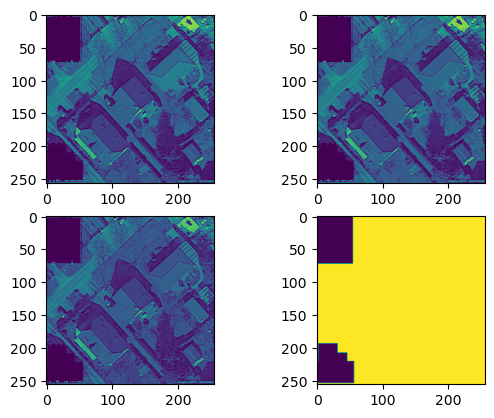

In [5]:
# Each image has 4 channels, I show it by an example

image_sample = read_image('./dida_test_task/images/553.png')

print("Data shape : " + str(image_sample.shape))
plt.subplot(221)
plt.imshow(image_sample[0])

plt.subplot(222)
plt.imshow(image_sample[1])

plt.subplot(223)
plt.imshow(image_sample[2])

plt.subplot(224)
plt.imshow(image_sample[3])


In [6]:
im_size = 256  #size of each image is 256*256*4

#If we transform the images into tensor, then we can compute mean and std for each layer 
mean = torch.tensor([183.9983, 67.7026, 70.3354, 128.6862]) 
std = torch.tensor([97.0688, 44.7028, 45.7865, 95.0175])

## Transformation

To increase the number of data (images), I apply some transforms on 25 labeled images and get new images with new labels.
So I need two different transforms to have 75 images as training data. Also, we can apply new transforms and create new and more images.

In [7]:

    
transform_1 = transforms.Compose([#transforms.Resize((im_size, im_size)), # Resize the image in a 32X32 shape
                                     transforms.RandomRotation(20), # Randomly rotate some images by 20 degrees
                                     transforms.RandomHorizontalFlip(0.1)]) # Randomly horizontal flip the images
                                     #transforms.ColorJitter(brightness = 0.1, # Randomly adjust color jitter of the images
                                                           # contrast = 0.1, 
                                                            #saturation = 0.1), 
                                     #transforms.RandomAdjustSharpness(sharpness_factor = 2,
                                                                   #   p = 0.1)] # Randomly adjust sharpness
                                     
                            
transform_2 = transforms.Compose([#transforms.Resize((im_size, im_size)), # Resize the image in a 32X32 shape
                                     #transforms.RandomRotation(20), # Randomly rotate some images by 20 degrees
                                     #transforms.RandomHorizontalFlip(0.1)]) # Randomly horizontal flip the images
                                     transforms.ColorJitter(brightness = 0.1, # Randomly adjust color jitter of the images
                                                           contrast = 0.1, 
                                                           saturation = 0.1), 
                                     transforms.RandomAdjustSharpness(sharpness_factor = 2,
                                                                      p = 0.1)]) # Randomly adjust sharpness
                                     

In [8]:
# Two useful functions to do normalization or denormalization
# To plot images we should do denormalization

def normalize(imge):
    img = imge.clone()
    if len(img.shape) == 4:
        for i in range(4):
            img[:,i,:,:] = (img[:,i,:,:] - mean[i]) / std[i]
    elif len(img.shape) == 3:
        for i in range(4):
            img[i,:,:] = (img[i,:,:] - mean[i]) / std[i]
    return img


def denormalzie(imge):
    img = imge.clone()
    if len(img.shape) == 4:
        for i in range(4):
            img[:,i,:,:] = (img[:,i,:,:] * std[i]) + mean[i]

    elif len(img.shape) == 3:
        for i in range(4):
            img[i,:,:] = (img[i,:,:] * std[i]) + mean[i]
    return img


In [9]:
Images = sorted(glob.glob(f'{images_dir}/*')) #Sort all images (with label or without label)
Labels = sorted(glob.glob(f'{labels_dir}/*')) #Sort labels 

## Creating our dataset (training + validation)

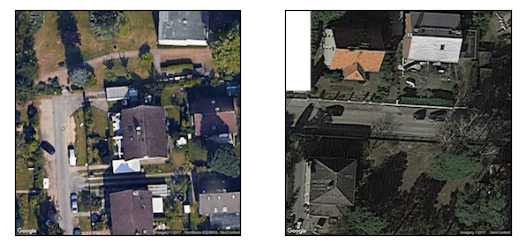

In [10]:
N = len(Labels) #Number of labeled images in the given dataset
n_channels, n_x, n_y = 4, 256, 256 #Images have 4 channels of size 256*256

images_tensor = torch.zeros(N, n_channels, n_x, n_y) 
labels_tensor = torch.zeros(N, 1, n_x, n_y)


# Seperate labeled images among all given images

images_and_labels = []

for idx, label in enumerate(Labels):
    img_l = label[:17] + "images" + label[-8:]
    labels_tensor[idx,:,:,:] = read_image(label)
    images_tensor[idx,:,:,:] = read_image(img_l)
              
    images_and_labels.append([img_l, label])

    
# Apply predefined transformations on the dataset (25 labeled images and creating a training set of size 75)
#'img' and 'label' give their saved paths (strings) of an image and its label, 
#and 'Image.open; turn a path to an image of type 'pil.image' so that we can apply our transforms.
#Then by 'F.pil_to_tensor' we turn the output to tensor. We do similar process to find the labels

for item in [transform_1, transform_2]:
    images_tensor_item = torch.zeros(N, n_channels, n_x, n_y)
    labels_tensor_item = torch.zeros(N, 1, n_x, n_y)
    for idx, (img, label) in enumerate(images_and_labels): 
        img_t = item(Image.open(img)) 
        images_tensor_item[idx,:,:,:] = F.pil_to_tensor(img_t)
        
        label_t = item(Image.open(label))
        label_t = F.pil_to_tensor(label_t)
        labels_tensor_item[idx,:,:,:] = label_t

    images_tensor = torch.cat([images_tensor, images_tensor_item])  #Concatenating three (images) dataset  which each of them has size 25  
    labels_tensor = torch.cat([labels_tensor, labels_tensor_item])  #Concatenating three (labels) dataset which each of them has size 25  

images_tensor = normalize(images_tensor) #Normalization of training data
labels_tensor = labels_tensor /255  #we push the values between [0, 1]

# Plot two of the images
show([denormalzie(images_tensor[0,:,:,:]).type(dtype = torch.uint8), denormalzie(images_tensor[1,:,:,:]).type(dtype = torch.uint8)])


In [11]:
images_tensor.shape #Shape of training data (training + validation)

torch.Size([75, 4, 256, 256])

In [12]:
labels_tensor.shape #Shape of the labels of training data (training + validation)

torch.Size([75, 1, 256, 256])

In [13]:
#Finally we create our training datase containing 75 images and their labels

train_dataset = TensorDataset(Tensor(images_tensor), Tensor(labels_tensor)) 

## We have to seperate a number of images and their labels as validation set

Randomly we assign 67 data for training set and 8 data for validation set

In [14]:
#We have to seperate a number of images and their labels as validation set
#Randomly we assign 68 data for training set and 7 data for validation set

train_data, valid_data = torch.utils.data.random_split(train_dataset, [68, 7])

In [15]:
len(train_data) #Size of training set

68

In [16]:
len(valid_data) #Size of validation set

7

In [17]:
# Creating train and validation batch for training

train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=2, shuffle=True)

Function 'train_model' contains three parts, the first and second part compute the loss functions for training and validation data and the third part calculate the mean of IOU mertic to give a better view of model performance

In [18]:
def train_model(model, train_loader, valid_loader, optimizer, n_epochs):
    
    # Global variable
    N_valid = len(valid_data)
    train_loss_list = []
    model = model.to(device)
    train_cost_list = []
    valid_cost_list = []
    IOU_sum = 0
   
  
    
    for epoch in range(n_epochs):
        train_COST = 0
        for img, label in train_loader:
            img = img.to(device)
            label = label.to(device)
            model.train()
            optimizer.zero_grad()
            output = model(img)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            train_COST += loss.item()
            
        train_COST = train_COST/len(train_loader)
        train_cost_list.append(train_COST)
        correct = 0
        
        # prediction on the validation data
        EPS = 1e-6
        iou_sum = 0
        valid_COST = 0
        for img_valid, label_valid in valid_loader:
            model.eval()
            img_valid = img_valid.to(device)
            label_valid = label_valid.to(device)
            label_pred = model(img_valid)
    
            valid_loss = criterion(label_pred, label_valid)
            valid_COST += valid_loss.item()
           
            intersection = torch.logical_and(label_valid, label_pred).sum().numpy() 
            union = torch.logical_or(label_valid, label_pred).sum().numpy() 
            iou_score = (intersection + EPS) / (union + EPS)
            iou_sum += iou_score
            
             
        
        valid_COST = valid_COST/ len(valid_loader)
        valid_cost_list.append(valid_COST)
        IOU_mean = iou_sum / len(valid_loader)
        
        IOU_sum += IOU_mean


        
        print("--> Epoch Number : {}".format(epoch + 1),
              " | Training Loss : {}".format(round(train_COST,4)),
              " | Validation Loss : {}".format(round(valid_COST,4)),
              " | Validation IOU : {}%".format(round(IOU_mean,2)* 100)
             )

    
        
    return train_cost_list, valid_cost_list


## Model: 

https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/

I apply a trained model (U-Net) on my data,
because the size of data is not large, creating a new model is not reasonable. 
So, I found a suitable trained model.

In [19]:

model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=4, out_channels=1, init_features=16, pretrained=False)
model = model.to(device) #Move to GPU

criterion = torch.nn.BCELoss() #Loss function: 'binary cross entropy'
optimizer = torch.optim.Adam(model.parameters(), lr=0.1) #Optimizer: 'Adam' with learning rate = 0.1


#Train the model

train_cost_list, valid_cost_list=train_model(model=model, train_loader=train_loader, valid_loader=valid_loader, optimizer=optimizer, n_epochs=60)


Using cache found in C:\Users\Leila/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


--> Epoch Number : 1  | Training Loss : 0.5723  | Validation Loss : 11.336  | Validation IOU : 0.0%
--> Epoch Number : 2  | Training Loss : 0.4084  | Validation Loss : 12.2368  | Validation IOU : 0.0%
--> Epoch Number : 3  | Training Loss : 0.3586  | Validation Loss : 8.7273  | Validation IOU : 18.0%
--> Epoch Number : 4  | Training Loss : 0.3604  | Validation Loss : 1.0802  | Validation IOU : 25.0%
--> Epoch Number : 5  | Training Loss : 0.3324  | Validation Loss : 1.2514  | Validation IOU : 23.0%
--> Epoch Number : 6  | Training Loss : 0.3625  | Validation Loss : 8.1031  | Validation IOU : 18.0%
--> Epoch Number : 7  | Training Loss : 0.3414  | Validation Loss : 9.869  | Validation IOU : 13.0%
--> Epoch Number : 8  | Training Loss : 0.3393  | Validation Loss : 3.7128  | Validation IOU : 23.0%
--> Epoch Number : 9  | Training Loss : 0.3305  | Validation Loss : 0.4659  | Validation IOU : 35.0%
--> Epoch Number : 10  | Training Loss : 0.3291  | Validation Loss : 0.3292  | Validation IOU

### Ploting and comparing loss function for training and validation data based on training iteration

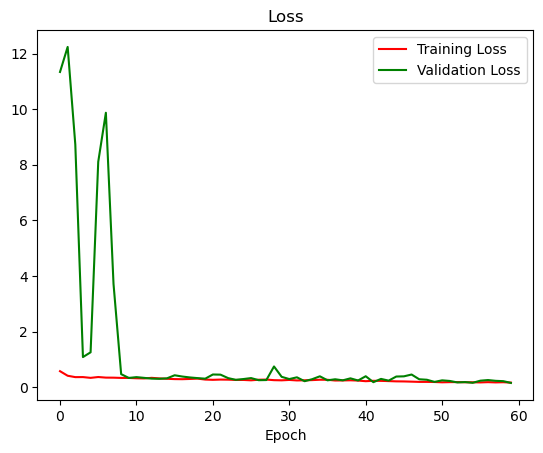

In [20]:
plt.plot(train_cost_list, 'r', label='Training Loss')
plt.plot(valid_cost_list,  'g',  label='Validation Loss')
plt.xlabel("Epoch")
plt.title("Loss")
plt.legend()

## Prepearing test data to apply the model

 Number of test data :  5


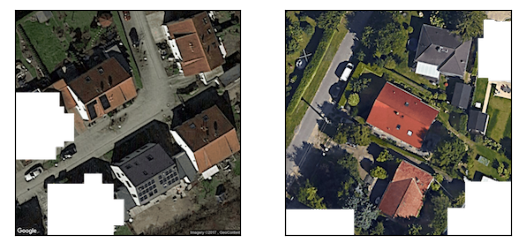

In [21]:

test_set = set(Images) - set(map(lambda img_label: img_label[0], images_and_labels))
n_test = len(test_set)
test_images = sorted(list(test_set))

test_tensor = torch.zeros(n_test, n_channels, n_x, n_y)

print(" Number of test data :  " + str(n_test))

for idx in range(n_test):
    test_tensor[idx,:,:,:] = read_image(test_images[idx])

    

test_tensor = normalize(test_tensor) # Normalizing test data using maean and std lists


show([denormalzie(test_tensor[0,:,:,:]).type(dtype = torch.uint8), denormalzie(test_tensor[1,:,:,:]).type(dtype = torch.uint8)])


### Two images (of training set) with estimated labels obtained from our model and real labels

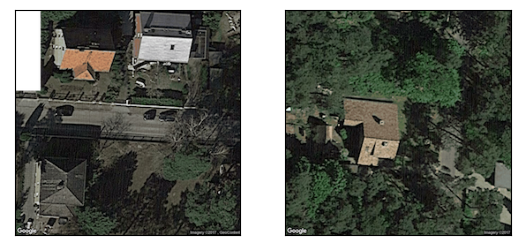

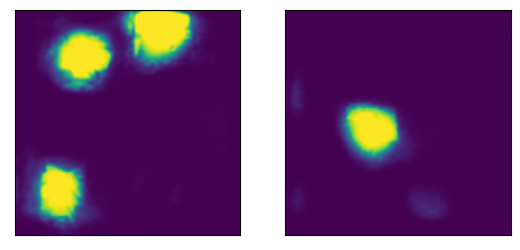

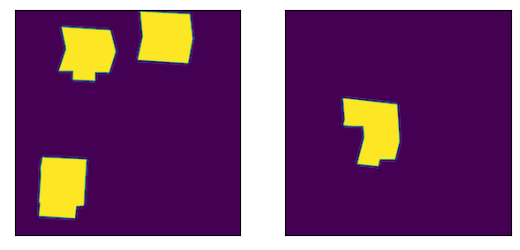

In [22]:
label_estimation = model(images_tensor[:10,:,:,:])

show([denormalzie(images_tensor[1,:,:,:]).type(dtype = torch.uint8), denormalzie(images_tensor[4,:,:,:]).type(dtype = torch.uint8)])

show([((label_estimation[1,:,:,:]*255)+0).type(dtype = torch.uint8), ((label_estimation[4,:,:,:]*255)+0).type(dtype = torch.uint8)])

show([((labels_tensor[1,:,:,:]*255)+0).type(dtype = torch.uint8), ((labels_tensor[4,:,:,:]*255)+0).type(dtype = torch.uint8)])


## Predict the label of test data using the model and save predicted labels

In [23]:

Label_test  = model(test_tensor[:,:,:,:])

target_dir = './dida_test_task/predicted_labels/'

Label_test_list = []
for idx, img in enumerate(test_images):
    Label_test_list.append(Label_test[idx,:,:,:])

for i, n in enumerate([535, 537,539, 551, 553]):
    img_grid_fake = torchvision.utils.make_grid(Label_test_list[i], nrow=1)
    filepath = os.path.join(target_dir, f"{n}.png")
    torchvision.utils.save_image(img_grid_fake, filepath)



Ploting two test images with the predicted labels

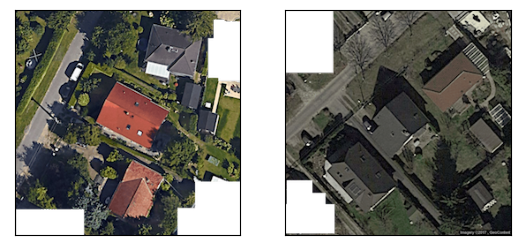

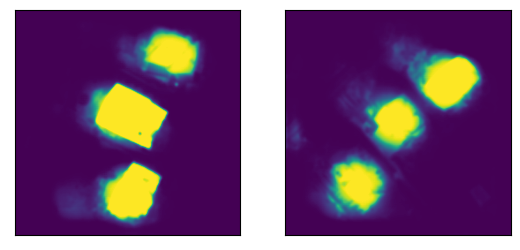

In [28]:
show([denormalzie(test_tensor[1,:,:,:]).type(dtype = torch.uint8), denormalzie(test_tensor[4,:,:,:]).type(dtype = torch.uint8)])
show([((Label_test[1,:,:,:]*255)+0).type(dtype = torch.uint8), ((Label_test[4,:,:,:]*255)+0).type(dtype = torch.uint8)])
